In [1]:
import cv2 as cv;
import numpy as np;
import matplotlib.pyplot as plt;
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
k = 1.414
sigma = 1.0

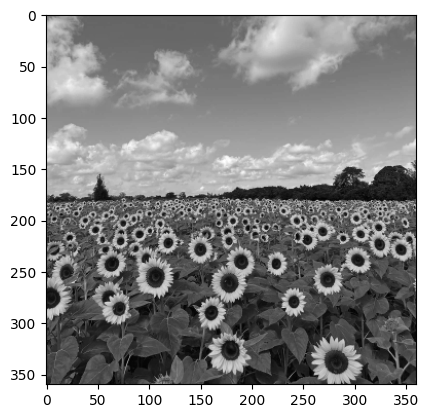

In [2]:
# Read image
sunflower = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
sunflower = cv.cvtColor(sunflower,cv.COLOR_BGR2GRAY)
sunflower = sunflower/255.0
#plt.imshow(sunflower,cmap='gray',vmin = 0,vmax=255)
plt.imshow(sunflower,cmap='gray')
h,w= sunflower.shape

In [3]:
#Generating LOG filter
def log_filter(sigma):
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) *  (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

In [4]:
#Convolving with Gaussian filters
def convolve(img):
    log_images = [] 
    for i in range(0,9):
        y = np.power(k,i) 
        sigma_1 = sigma*y 
        filter_log = log_filter(sigma_1)
        image = cv.filter2D(img,-1,filter_log) 
        image = np.pad(image,((1,1),(1,1)),'constant') 
        image = np.square(image) 
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) 
    return log_image_np

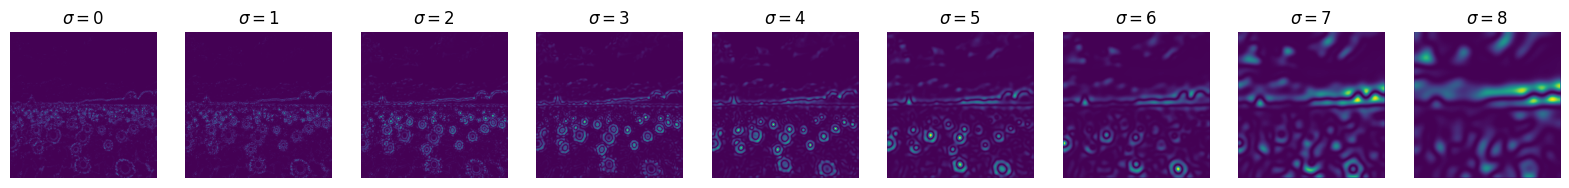

In [5]:
img01 = convolve(sunflower)
fig, ax = plt.subplots(1, 9, figsize=(20,5))
for i in range(9):
    ax[i].imshow(img01[i])
    ax[i].axis('off')
    ax[i].set_title(r'$\sigma = {}$'.format(i))    

In [6]:
def blob(img,h,w):
    co_ordinates = [] 
    for i in range(1,h):
        for j in range(1,w):
            slice_img = img[:,i-1:i+2,j-1:j+2] 
            result = np.amax(slice_img) 
            if result >= 0.03: 
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma))
    return co_ordinates

In [7]:
co_ordinates = list(set(blob(img01,h,w)))
nh,nw = sunflower.shape
count = 0

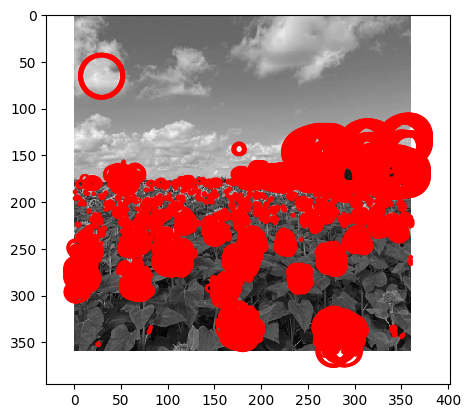

In [8]:
fig, ax = plt.subplots()
ax.imshow(sunflower, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

In [9]:
import math
from math import sqrt
#To remove overlaps
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)
    #print(n_dim)
    
    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)

        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)

    a = -d + r2 + r1
    b = d - r2 + r1
    c = d + r2 - r1
    d = d + r2 + r1

    area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
    return area/(math.pi * (min(r1, r2) ** 2))


In [10]:
def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0
    
    return np.array([b for b in blobs_array if b[-1] > 0])

In [11]:
co_ordinates = np.array(co_ordinates)
co_ordinates = redundancy(co_ordinates,0.5)

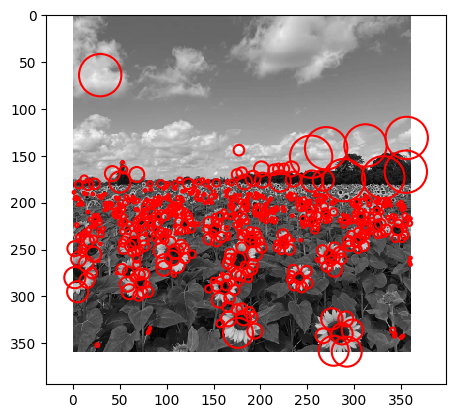

In [12]:
fig, ax = plt.subplots()
ax.imshow(sunflower, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

Question 02

In [13]:
from scipy.optimize import minimize
from scipy import linalg
import tikzplotlib

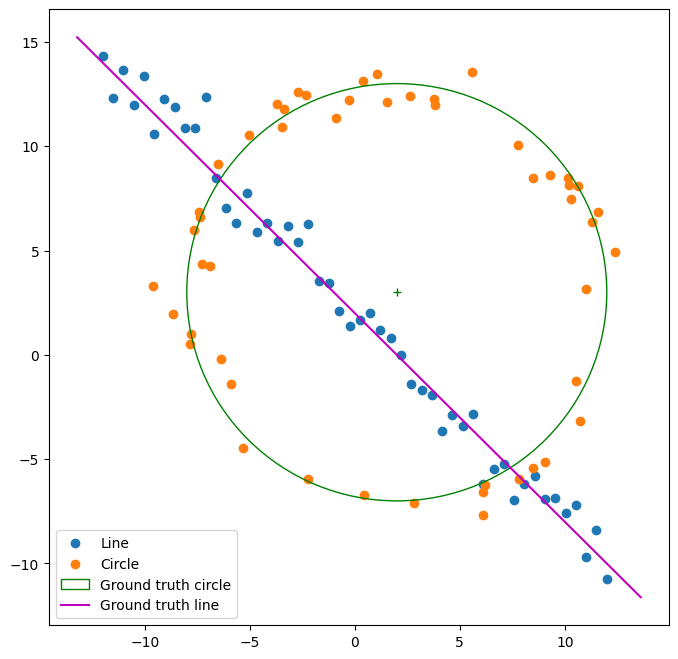

In [14]:
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 
s = r /16
t = np.random.uniform(0 , 2*np . pi , half_n )
n = s*np.random.randn( half_n )
x , y = x0_gt + ( r + n)*np.cos( t ) , y0_gt + ( r + n)*np.sin ( t )
X_circ = np.hstack( ( x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )
X_line = np.hstack(( x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )
X = np.vstack( ( X_circ , X_line ) ) 
fig , ax = plt.subplots(1 ,1 ,figsize =(8 ,8))
ax.scatter( X_line[ : , 0 ] , X_line[ : , 1 ] , label= 'Line' )
ax.scatter( X_circ[ : , 0 ] , X_circ[ : , 1 ] , label=  'Circle')
circle_gt = plt.Circle( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label=  'Ground truth circle' )
ax.add_patch(circle_gt)
ax.plot( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g' )
x_min , x_max = ax.get_xlim( )
x_ = np.array( [ x_min , x_max ] )
y_ = m*x_ + b
plt.plot( x_ , y_ , color= 'm', label=  'Ground truth line' )
plt.legend( )

In [15]:
N = X.shape[0]
X_ = X

In [16]:
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

In [17]:
def line_tls(x,indices):
    a,b,d = x[0],x[1],x[2]
    return np.sum(np.square(a*X_[indices,0]+b*X_[indices,1]-d))

In [18]:
def g(x):
    return x[0]**2 + x[1]**2 - 1

In [19]:
cons = ({'type':'eq','fun':g})

def consensus_line(X_,x,t):
    a,b,d = x[0],x[1],x[2]
    error = np.absolute(a*X_[:,0]+b*X_[:,1]-d)
    return error < t

In [20]:
t = 1
d = 0.4*N
s = 2

inliers_line = []
max_iterations = 50
iteration = 0
best_model_line = []
best_error = np.inf
best_sample_line = []
res_only_with_sample = []
best_inliers_line = []

In [21]:
while iteration<max_iterations:
    indices = np.random.randint(0,N,s)
    x0 = np.array([1,1,0])
    res = minimize(fun = line_tls,args = indices,x0=x0,tol=1e-6,constraints = cons, options = {'disp':True})
    inliers_line = consensus_line(X_,res.x,t)
    print('rex.x: ',res.x)
    print('Iteration = ',iteration,'. No. inliers = ',inliers_line.sum())
    if inliers_line.sum()>d:
       x0 = res.x
       res = minimize(fun=line_tls,args=inliers_line,x0=x0,tol = 1e-6, constraints = cons, options = {'disp':True})
       print(res.x,res.fun)
       if res.fun<best_error:
           print('A better model found...',res.x,res.fun)
           best_model_line = res.x
           best_error = res.fun
           best_sample_line = X_[indices,:]
           res_only_with_sample = x0 
           best_inliers_line = inliers_line

    iteration += 1

print('Best line model',best_model_line)    


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9214939798985117e-08
            Iterations: 8
            Function evaluations: 35
            Gradient evaluations: 8
rex.x:  [ 0.18679076  0.98239975 -5.39804792]
Iteration =  0 . No. inliers =  13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.10268305407767e-08
            Iterations: 14
            Function evaluations: 66
            Gradient evaluations: 14
rex.x:  [-0.88641248  0.46289624 -8.30340359]
Iteration =  1 . No. inliers =  8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.6298045703600905e-07
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
rex.x:  [0.93856772 0.34509555 3.08140619]
Iteration =  2 . No. inliers =  12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2065449189845462e-07
            

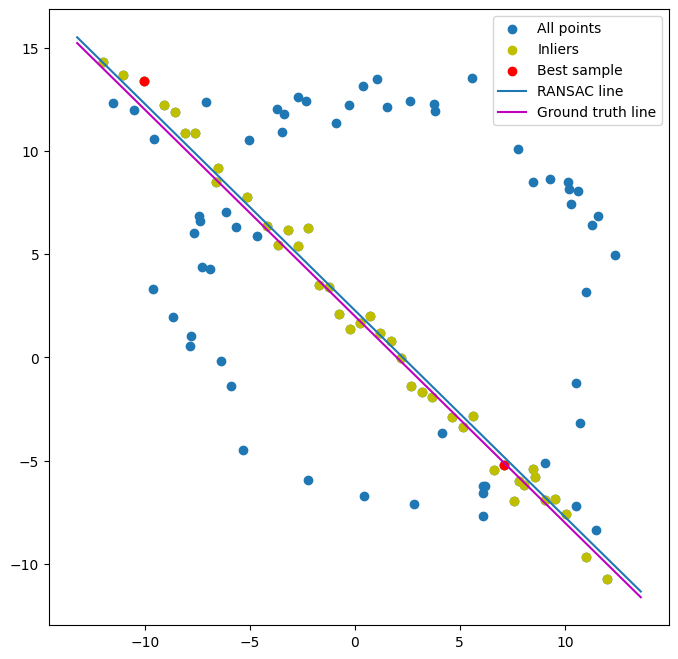

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:,0],X[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

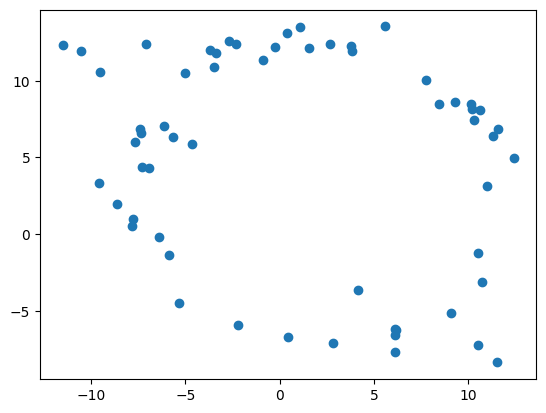

In [23]:
circle = X[~best_inliers_line]
X_circle = circle 
N = circle.shape[0]
plt.scatter(X_circle[:,0],X_circle[:,1], label='All points')

In [24]:
t = 1
d = 0.6*N
s = 3

inliers_circle = []
max_iterations = 50
iteration = 0
best_model_circle = []
best_error = np.inf
best_sample_circle = []
res_only_with_sample = []
best_inliers_circle = []

In [25]:
def circle_tls(x, indices):
    a, b, r = x[0], x[1], x[2]
    return np.sum(np.square(np.sqrt(np.square(X_circle[indices,0] - a) + np.square(X_circle[indices,1] - b))-r))

def consensus_circle(X, x, t):
    a, b, r = x[0], x[1], x[2]
    error = np.absolute(np.sqrt(np.square(X_circle[:,0] - a) + np.square(X_circle[:,1] - b))-r)
    return error < t

def g(x):
    return [10 - x[0], 10 - x[1]]


In [26]:
cons = ({'type': 'ineq', 'fun': g})

In [27]:
while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 1]) # Initial estimate
    res = minimize(fun = circle_tls, args = indices, constraints = cons, x0 = x0, tol= 1e-6)
    inliers_circle = consensus_circle(X_circle, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ',  inliers_circle.sum())
    print(circle_tls(res.x, indices))
    if inliers_circle.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = circle_tls, args = inliers_circle, x0 = x0, tol= 1e-6, constraints=cons)
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_circle = res.x
            best_eror = res.fun
            best_sample_circle = X_circle[indices,:]
            res_only_with_sample = x0
            best_inliers_circle = inliers_circle

    iteration += 1

print('Best circle model', best_model_circle)

rex.x:  [ 7.62127463 10.         16.58204276]
Iteration =  0 . No. inliners =  9
0.7777852896911763
rex.x:  [ 1.03213144  2.16017328 11.09090452]
Iteration =  1 . No. inliners =  26
1.4216630619952555e-08
rex.x:  [  10.         -144.88376755  158.16332921]
Iteration =  2 . No. inliners =  14
0.044707288637817186
rex.x:  [ 2.61689565  1.69174655 10.24938824]
Iteration =  3 . No. inliners =  28
2.906297275247734e-07
rex.x:  [ 2.41553705  3.33896072 10.24704026]
Iteration =  4 . No. inliners =  36
1.1877224550269557e-07
[ 2.25971234  3.12852648 10.11120564] 8.815364066867389
A better model found ...  [ 2.25971234  3.12852648 10.11120564] 8.815364066867389
rex.x:  [1.51468558 2.84237041 9.68816843]
Iteration =  5 . No. inliners =  39
6.653276720624247e-12
[1.67240711 2.79060467 9.86285519] 9.191134377499854
A better model found ...  [1.67240711 2.79060467 9.86285519] 9.191134377499854
rex.x:  [-9.74223826 -1.38525137 13.8139885 ]
Iteration =  6 . No. inliners =  9
6.967018700176297e-08
rex

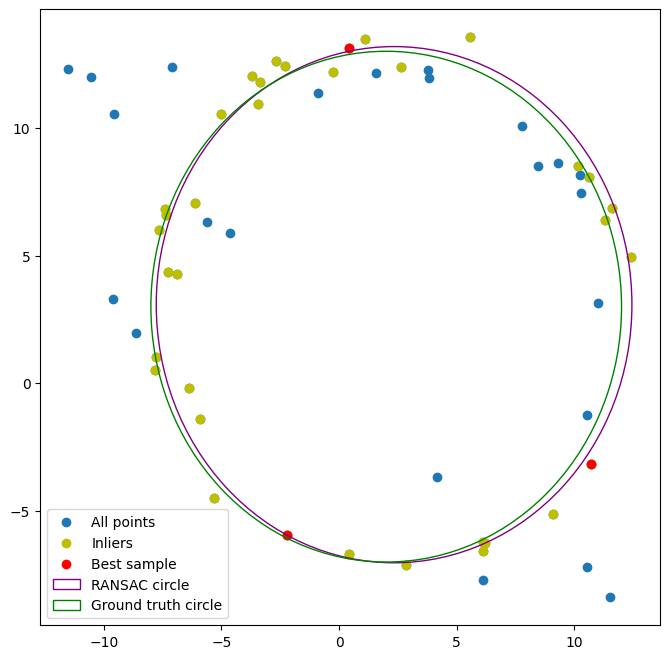

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(circle[:,0],circle[:,1], label='All points')
ax.scatter(X_circle[best_inliers_circle,0],X_circle[best_inliers_circle,1], color='y', label='Inliers')
ax.scatter(best_sample_circle[:,0],best_sample_circle[:,1], color='r', label='Best sample')
circle_gt = plt.Circle( ( best_model_circle[0] , best_model_circle[1] ) , best_model_circle[2] , color= 'purple' , fill =False , label=  'RANSAC circle' )
ax.add_patch(circle_gt)
circle_gt = plt.Circle( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label=  'Ground truth circle' )
ax.add_patch(circle_gt)
plt.legend()

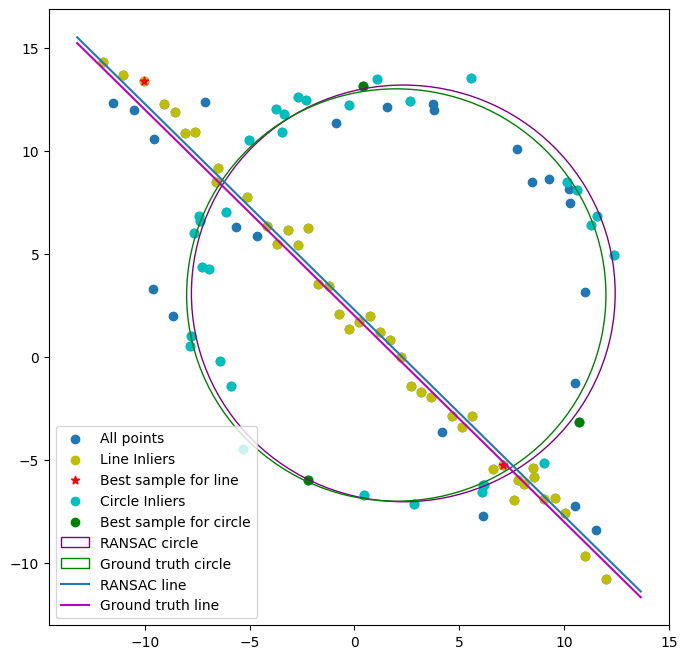

In [29]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:,0],X[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample for line',marker='*')
ax.scatter(X_circle[best_inliers_circle,0],X_circle[best_inliers_circle,1], color='c', label='Circle Inliers')
ax.scatter(best_sample_circle[:,0],best_sample_circle[:,1], color='g', label='Best sample for circle')
circle_gt = plt.Circle( ( best_model_circle[0] , best_model_circle[1] ) , best_model_circle[2] , color= 'purple' , fill =False , label=  'RANSAC circle' )
ax.add_patch(circle_gt)
circle_gt = plt.Circle( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label=  'Ground truth circle' )
ax.add_patch(circle_gt)
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

Question 03

In [30]:
N = 4 # Number of points
global n
n = 0

# Parameters of the two images
post_pts = np.empty((N,2))
face_pts= np.empty((N,2))

In [31]:
def draw_circle(event,x,y,flags,param):
    global n
    p = param[0]
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(param[1],(x,y),5,(255,0,0),-1)
        p[n] = (x,y)
        n += 1

In [32]:
poster = cv.imread('post.png', cv.IMREAD_COLOR)
face = cv.imread('tattoo.png', cv.IMREAD_COLOR)
face = face[0:900,50:600]
poster_copy = poster.copy()
face_copy = face.copy()

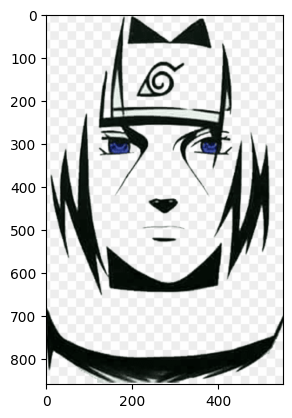

In [33]:
plt.imshow(face)

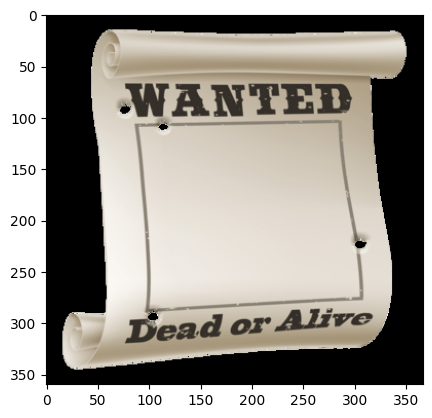

In [51]:
plt.imshow(cv.cvtColor(poster,cv.COLOR_BGR2RGB))

In [35]:
cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
param = [post_pts, poster_copy]
cv.setMouseCallback('Image',draw_circle, param)
while(1):
    cv.imshow('Image', poster_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break
cv.destroyAllWindows()        

In [36]:
face_pts = np.float32([[0,900],[0,0],[600,0],[600,900]])

In [37]:
h, status = cv.findHomography(post_pts, face_pts) # Calculating homography between image and flag
print(h)


[[ 2.85031602e+00 -1.77138284e-01 -2.28492282e+02]
 [ 5.37298815e-02  5.34612321e+00 -5.92748053e+02]
 [-2.95620671e-04  2.82340612e-04  1.00000000e+00]]


In [38]:
warped_img = cv.warpPerspective(face, np.linalg.inv(h), (poster.shape[1],poster.shape[0]))

In [39]:
# Blending
alpha = 0.5
beta = 1-alpha

blended = cv.addWeighted(poster, alpha, warped_img, beta, 0.0)

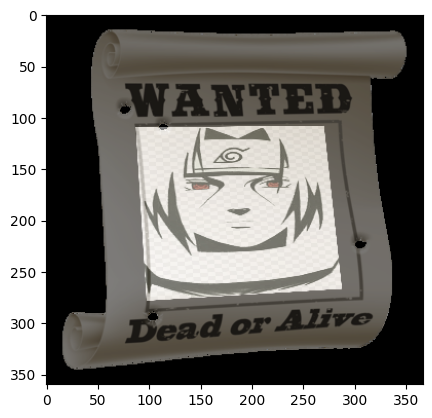

In [40]:
plt.imshow(cv.cvtColor(blended,cv.COLOR_BGR2RGB))

Question 04

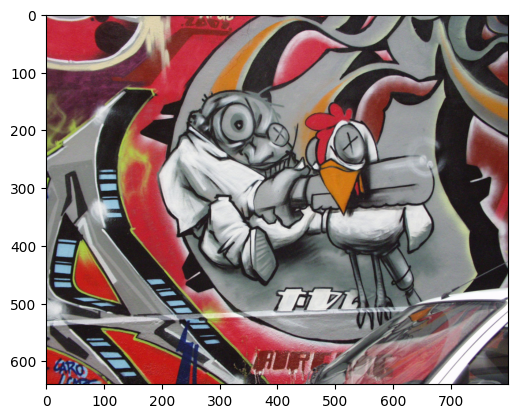

In [2]:
img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

plt.imshow(img1)

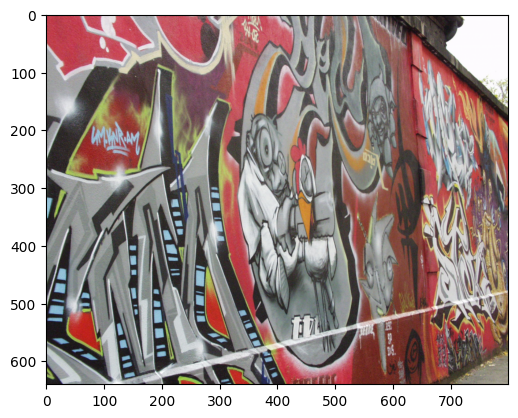

In [3]:
plt.imshow(img5)

((< cv2.DMatch 0000023958AD4AB0>, < cv2.DMatch 0000023958B56C70>), (< cv2.DMatch 0000023958B56390>, < cv2.DMatch 0000023958B56E70>), (< cv2.DMatch 0000023958B56C10>, < cv2.DMatch 0000023958B56D90>), (< cv2.DMatch 000002395B4266B0>, < cv2.DMatch 000002395B426210>), (< cv2.DMatch 000002395B426650>, < cv2.DMatch 000002395B426590>))


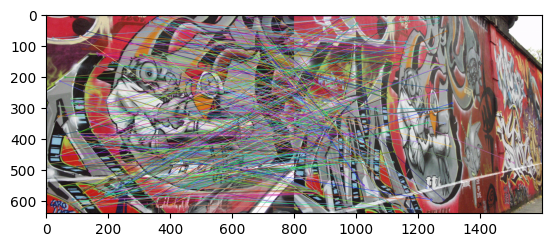

In [4]:
sift = cv.SIFT_create()
bf = cv.BFMatcher()

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = bf.knnMatch(des1, des5, k=2)
print(matches[:5])
matches = sorted(matches, key=lambda x:x[0].distance)

out_img = cv.drawMatchesKnn(img1, key1, img5, key5, matches[:200], img5, flags=2) #only draw best 200 matches
plt.imshow(out_img)

In [6]:
def findFeatures(img):
    sift = cv.SIFT_create()
    key, des = sift.detectAndCompute(img, None)
    return key, des

In [7]:
def findMatches(des1, des5):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des5, k=2)
    return matches

In [8]:
def calHomography(sample):
    A = []
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

In [9]:
def calDistance(H, correspondence):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [10]:
def RANSAC(corres,threshold):
    max_inliers = []
    homography = []

    #(int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4)))

    for i in range(100):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr4))
        
        
        h = calHomography(sample)
        inliers = np.zeros((1,4))
        
        for j in range(len(corres)):
            distance = calDistance(h, corres[j])
            if distance < 5:
                inliers = np.vstack((inliers,corres[j]))
               
        inliers = np.delete(inliers,0,0)

        if len(inliers) > threshold:
            max_inliers = inliers
            homography = calHomography(max_inliers)
       
    return homography,max_inliers

In [11]:
img_lst = []
for i in range(1,6):
    img = cv.imread('img'+str(i)+'.ppm')
    img_lst.append(img)


homographs = []
estimated_threshold = 100

for i in range(4):
    correspondence = []
    key1, des1 = findFeatures(img_lst[i])
    key5, des5 = findFeatures(img_lst[i+1])
    keypoints = [key1, key5]
    matches = findMatches(des1, des5)

    for match in matches:
        (x1, y1) = keypoints[0][match[0].queryIdx].pt
        (x2, y2) = keypoints[1][match[0].trainIdx].pt
        correspondence.append([x1, y1, x2, y2])

    corres = np.matrix(correspondence)
    H,inliers =RANSAC(corres,estimated_threshold)
    homographs.append(H)

final_homograph = homographs[3]@homographs[2]@homographs[1]@homographs[0]
final_homograph = (1/final_homograph.item(8))*final_homograph
print('Calculated Homography\n',final_homograph)

Calculated Homography
 [[ 5.66412013e-01 -6.85899467e-02  2.41457049e+02]
 [ 1.89102547e-01  8.78348225e-01  2.86796444e+01]
 [ 4.45369358e-04 -3.51198062e-04  1.00000000e+00]]


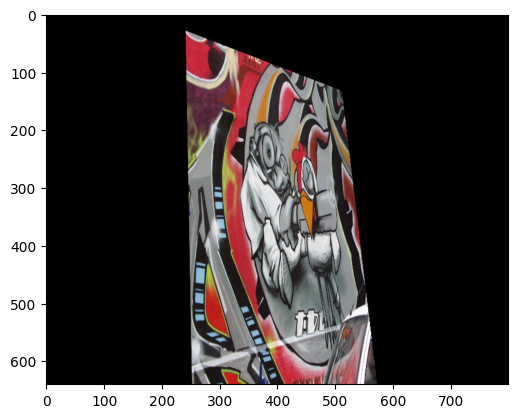

In [12]:
calculated_H = final_homograph
image_perspective = cv.warpPerspective(img1, calculated_H, (img5.shape[1], img5.shape[0]))
plt.imshow(image_perspective)

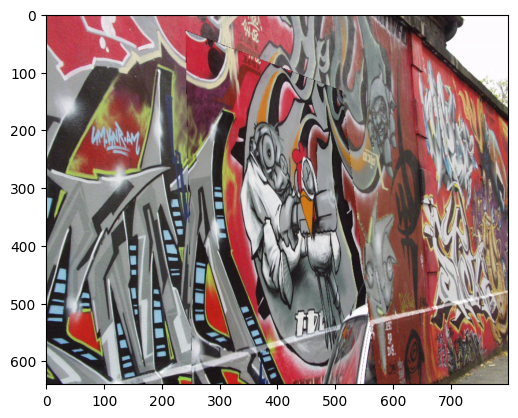

In [13]:
threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_RGB2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
plt.imshow(dst)

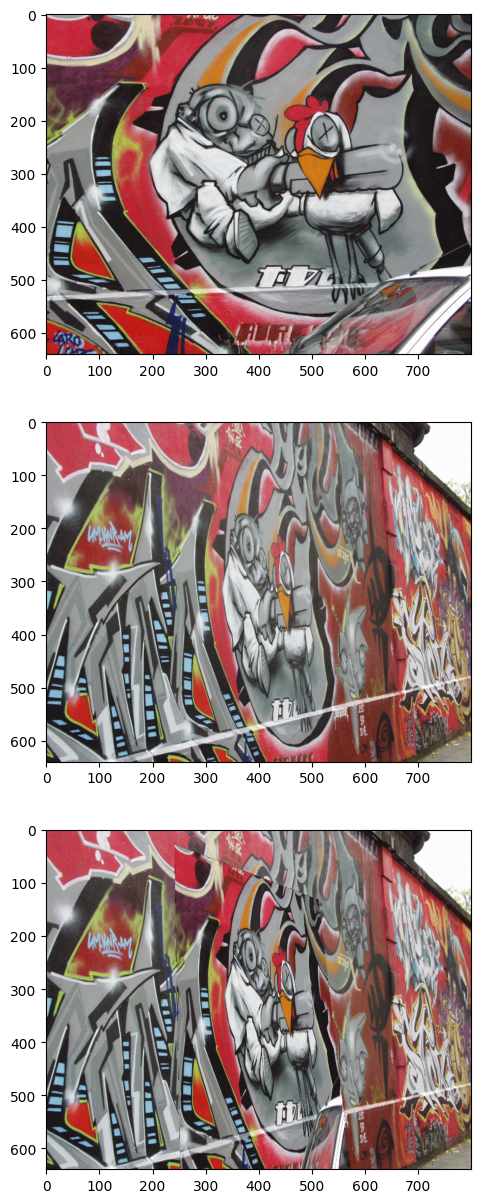

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(15,15))
ax[0].imshow(img1)
ax[1].imshow(img5)
ax[2].imshow(dst)